### this script plots the comparison between actual number with adjusted number in latest wos and the actual number in the used dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import numpy as np
import os

In [2]:
adjusted_path = "../../data/NationalFunding/Data/RobustCheck/check_09_and_18/global_us_chn_stats_adjusted.csv"
used_data_path = "../../data/NationalFunding/Data/DerivedData/CleanedRawData/pub.pkl"

In [16]:
adjusted_df = pd.read_csv(adjusted_path)
adjusted_df.head()

,cntry,year,total,funded,funded_estimated,estimated_lower,estimated_upper
0,china,2009,122394,88044,9.831465e+04,9.820844e+04,9.842086e+04
1,china,2018,393720,337747,3.491807e+05,3.490420e+05,3.493195e+05
2,global,2009,1038638,531320,6.135258e+05,6.126026e+05,6.144491e+05
3,global,2018,1548696,1051390,1.078351e+06,1.077757e+06,1.078944e+06
4,usa,2009,280877,163769,1.946214e+05,1.943424e+05,1.949004e+05


In [11]:
used_data = pd.read_pickle(used_data_path)
used_data.head(2)

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[Canada, United States]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0


#### get the number of papers that are funded every year in the used dataset

In [12]:
year_funded_global = used_data[used_data.funder!='Not-Funded'].groupby(['year']).size().reset_index(name='used_total')
year_funded_global['cntry']='global'
year_funded_cntry = used_data[used_data.funder_distinct!='Not-Funded'
                             ].explode(['author_distinct']).groupby(['author_distinct','year']).size().reset_index(name='used_total')
year_funded_cntry = year_funded_cntry[year_funded_cntry.author_distinct.isin(['United States','China'])]
year_funded_cntry.rename(columns={'author_distinct':'cntry'},inplace=True)
year_funded_cntry.replace(to_replace={'cntry':{'United States':'usa','China':'china'}},inplace=True)
year_funded = pd.concat([year_funded_global,year_funded_cntry])

In [13]:
year_funded = year_funded.set_index(['cntry','year'])
year_funded.head(2)

used_total
cntry  year            
global 2009      497411
       2010      592070

In [17]:
adjusted_df = adjusted_df.set_index(['cntry','year'])
adjusted_df.head(2)

total  funded  funded_estimated  estimated_lower  estimated_upper
cntry year                                                                    
china 2009  122394   88044      98314.650000     98208.439594     98420.860406
      2018  393720  337747     349180.707961    349041.958827    349319.457096

#### build the dataframe for plot

In [18]:
cntrys=['global','usa','china']
years = [2009,2018]
plot_df = []
for cntry, year in itertools.product(cntrys, years):
    
    total = adjusted_df.loc[(cntry,year),'total'] #get the total number of pubs in latest wos
    funded = adjusted_df.loc[(cntry,year),'funded'] #get the actual funded number of pubs in latest wos
    funded_ratio = funded/total
    plot_df.append([cntry,year,'funded',funded,funded_ratio])
    
    estimated = adjusted_df.loc[(cntry,year),'funded_estimated'] #get the adjusted funded number of pubs in latest wos
    estimated_ratio = estimated/total
    plot_df.append([cntry,year,'estimated',estimated,estimated_ratio])
 
    covered = year_funded.loc[(cntry,year),'used_total'] # number of funded in the analysis
    covered_ratio = covered/estimated # covered in our analysis vs anticipated
    plot_df.append([cntry,year,'covered',covered,covered_ratio])
    
plot_df = pd.DataFrame(plot_df,columns=['cntry','year','type','value','ratio'])

In [19]:
plot_df

,cntry,year,type,value,ratio
0,global,2009,funded,5.313200e+05,0.511555
1,global,2009,estimated,6.135258e+05,0.590702
2,global,2009,covered,4.974110e+05,0.810742
3,global,2018,funded,1.051390e+06,0.678887
4,global,2018,estimated,1.078351e+06,0.696296
5,global,2018,covered,9.809650e+05,0.909690
6,usa,2009,funded,1.637690e+05,0.583063
7,usa,2009,estimated,1.946214e+05,0.692906
8,usa,2009,covered,1.538890e+05,0.790710
9,usa,2018,funded,2.578870e+05,0.708020


In [20]:
def plot_bar(data,cntry, title):
    
    df = data[data.cntry==cntry]

    color = {'funded':'#88D4F2','estimated':'#007DCC','covered':'#87B15B'}
    hatches = {'funded':'//','estimated':'//','covered':None}
    label = {'funded':'Funded in\nlatest WoS','estimated':'Adjusted Funded\nin latest WoS','covered':'Used in\nanalysis'}

    groups = [2009,2018]
    order = ['funded','estimated','covered']

    x = np.arange(len(groups))
    width = 0.25
    multiplier = 0

    fig, ax = plt.subplots()

    for type_value in order:
        offset = width*multiplier
        values = df[df.type==type_value]['value'].values
        bars = ax.bar(x+offset, values, width=width, color=color[type_value],
                      hatch=hatches[type_value],edgecolor='#BFBFBF',label=label[type_value])
        if type_value!='covered':
            labels = df[df.type==type_value]['ratio'].values
            labels = ['{:.1%}'.format(value) for value in labels]
            ax.bar_label(bars, labels, padding=1, fmt='%.1f%%')

        multiplier +=1


    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)   
    ax.set_xlabel(" ")
    ax.set_ylabel("Number of Publications",fontsize=12)
    ax.legend(loc='upper left',frameon=False)
    ax.set_xticks(x+width, groups)
    
    ax.set_title(title, fontsize=15)
    
    return fig, ax

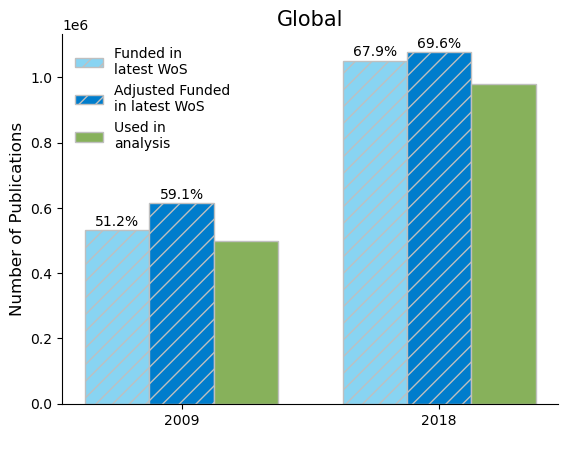

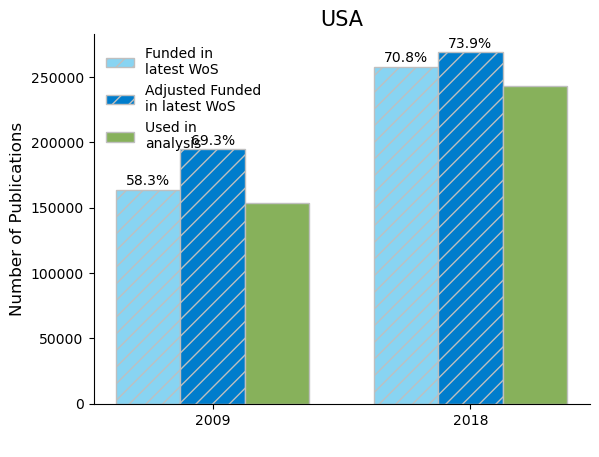

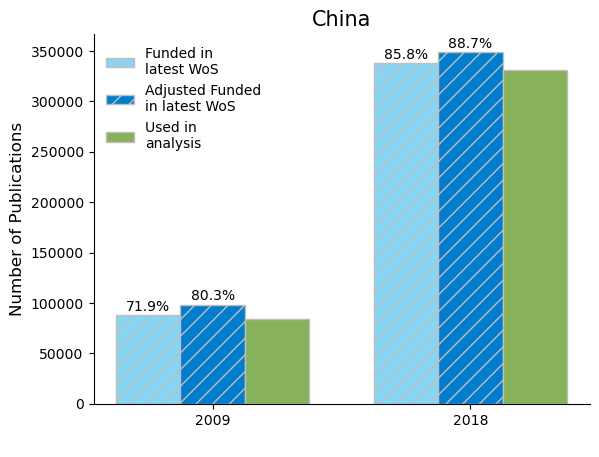

In [21]:
cntrys=['global','usa','china']
titles = ['Global','USA','China']
dir = "../../data/NationalFunding/Data/RobustCheck/check_09_and_18/"
for ind, cntry in enumerate(cntrys):
    fig,ax = plot_bar(plot_df,cntry,titles[ind])
    path = os.path.join(dir,cntry+'.pdf')
    plt.savefig(path,bbox_inches='tight')